In [21]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import quandl
import math
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy

#### assume annual volatility is 10%
#### formula: S(t) = S0 * exp( t * (drift - 0.5*volatility^2) + volatility * GBM )

In [22]:
# assume annual volatility is 10%
# formula: S(t) = S0 * exp( t * (drift - 0.5*volatility^2) + volatility * GBM )

def simulateIRR(drift, volatility, T, N, S0, GBP_cashflow, dates):
    global W
    global A
    global C
    global S
    global USD_cashflow
    global IRR
    global USD_cashflow_hedged
    global IRR_hedged
    
    W=[]
    A=[]
    C=[]
    S=[]
    USD_cashflow = []
    IRR=[]
    IRR_hedged=[]

    t = np.array(range(T+1))

    for i in range(N):
        b = np.random.normal(0,1,T)
        w = np.insert(np.cumsum(b),0,0)
        W.append(w)
        a  =  t * (drift-0.5*(volatility)**2)  +  volatility * w
        A.append(a)
        C.append(np.exp(a))
        S.append(S0 * np.exp(a))

    
    plt.figure(figsize=(15,8))
    plt.subplot(2,2,1)
    for i in W:
        plt.plot(t,i)
        plt.title('Cumulative GBM')
        plt.xticks(t,dates)
    
    plt.subplot(2,2,2)
    for i in A:
        plt.plot(t,i)
        plt.title('Adding zero drift and 10% annual volatility')
        plt.xticks(t,dates)
    
    plt.subplot(2,2,3)
    for i in C:
        plt.plot(t,i)
        plt.title('Exponentiate')
        plt.xticks(t,dates)
    
    plt.subplot(2,2,4)
    for i in S:
        plt.plot(t,i)
        plt.title('GBPUSD S0=1.3925')
        plt.xticks(t,dates)
    
    plt.show()

    
    for i in S:
        USD_cashflow.append(GBP_cashflow * i)

    for i in USD_cashflow:
        irr = round(npf.irr(i),4)   # np.irr is being deprecated, recommend using npf.irr (from the numpy_financial package)
        IRR.append(irr)
 
    global S5
    S5=[]
    for i in S:
        S5.append(i[5])

    global payoff
    payoff = []
    for i in S5:
        payoff.append(max(0,K-i))

    global option_payment
    option_payment = round(GBP_notional_amt * np.mean(payoff),0)/10**6

    
    USD_cashflow_hedged = copy.deepcopy(USD_cashflow)
    for i in range(len(USD_cashflow_hedged)):
        USD_cashflow_hedged[i][0] -= option_payment
        USD_cashflow_hedged[i][T] = (GBP_cashflow[T] - GBP_notional_amt/10**6) * S5[i] + GBP_notional_amt/10**6 * max(K,S5[i])
        # USD_cashflow_hedged[i][T] = 15 * S5[i] + 100 * max(K,S5[i])

        
    for i in USD_cashflow_hedged:
        irr_hedged = round(npf.irr(i),4)
        IRR_hedged.append(irr_hedged)
    
    
    TVaR95 = np.mean(sorted(IRR)[-int(N*0.05):])
    TVaR5 = np.mean(sorted(IRR)[:int(N*0.05)])
    TVaR95_hedged = np.mean(sorted(IRR_hedged)[-int(N*0.05):])
    TVaR5_hedged = np.mean(sorted(IRR_hedged)[:int(N*0.05)])
    
    
    print('IRR median: ', round(100*np.median(IRR),2), '%')
    print('IRR SD: ', round(100*np.std(IRR),2), '%')
    print('IRR 95% percentile: ', round(100*np.percentile(IRR,95),2), '%')
    print('IRR 5% percentile: ', round(100*np.percentile(IRR,5),2), '%')
    print('IRR TVaR 0.95 is ', round(100*TVaR95,2), '%')
    print('IRR TVaR 0.05 is ', round(100*TVaR5,2), '%')
    print('')
    print('Option value/premium: $', np.mean(payoff), 'USD per 1 notional amount of GBP')
    print('For 100,000,000 notional GBP, option premium is $', round(GBP_notional_amt * np.mean(payoff),0), 'USD')
    print('')
    print('Hedged IRR median: ', round(100*np.median(IRR_hedged),2), '%')
    print('Hedged IRR SD: ', round(100*np.std(IRR_hedged),2), '%')
    print('Hedged IRR 95% percentile: ', round(100*np.percentile(IRR_hedged,95),2), '%')
    print('Hedged IRR 5% percentile: ', round(100*np.percentile(IRR_hedged,5),2), '%')
    print('Hedged IRR TVaR 0.95 is ', round(100*TVaR95_hedged,2), '%')
    print('Hedged IRR TVaR 0.05 is ', round(100*TVaR5_hedged,2), '%')

    

In [23]:
dates = ['2021/3/31','2022/3/31','2023/3/31','2024/3/31','2025/3/31','2026/3/31']
T = 5
N = 1000
S0 = 1.3925
K = 1.3925
drift = 0
volatility = 0.1
GBP_cashflow = [-100,15,15,15,15,115]
GBP_notional_amt = 100000000

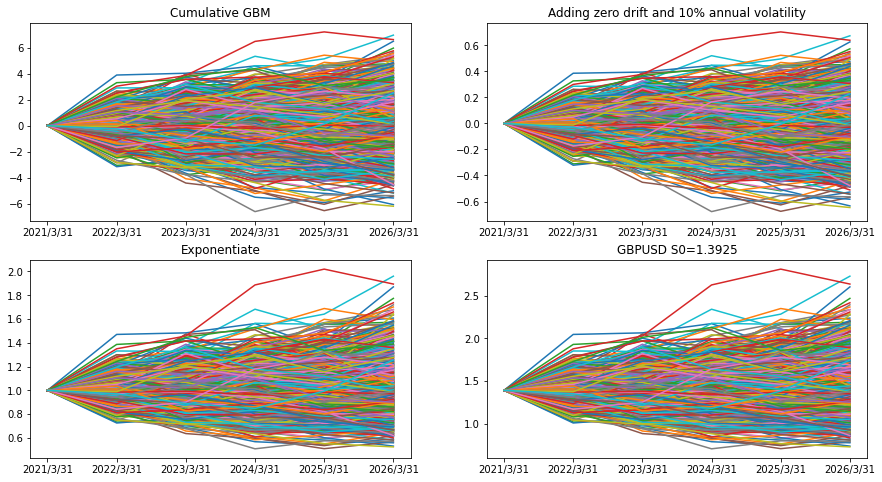

IRR median:  14.38 %
IRR SD:  5.22 %
IRR 95% percentile:  23.79 %
IRR 5% percentile:  6.19 %
IRR TVaR 0.95 is  25.89 %
IRR TVaR 0.05 is  4.41 %

Option value/premium: $ 0.12299633911320076 USD per 1 notional amount of GBP
For 100,000,000 notional GBP, option premium is $ 12299634.0 USD

Hedged IRR median:  12.61 %
Hedged IRR SD:  3.59 %
Hedged IRR 95% percentile:  21.09 %
Hedged IRR 5% percentile:  9.44 %
Hedged IRR TVaR 0.95 is  23.16 %
Hedged IRR TVaR 0.05 is  8.77 %


In [24]:
simulateIRR(drift, volatility, T, N, S0, GBP_cashflow, dates)

### Now, how to reduce variance of estimated IRR distribution in Monte Carlo simulations ?

### Answer: use either control variate method or antithetic method

### Antithetic method: use the exact opposite paths of the the first 500 simulated GBM paths

## Antithetic Monte Carlo

In [25]:
# assume annual volatility is 10%
# formula: S(t) = S0 * exp( t * (drift - 0.5*volatility^2) + volatility * GBM )

def antitheticIRR(drift, volatility, T, N, S0, GBP_cashflow, dates):
    global W
    global A
    global C
    global S
    global USD_cashflow
    global IRR
    global USD_cashflow_hedged
    global IRR_hedged
    
    W=[]
    A=[]
    C=[]
    S=[]
    USD_cashflow = []
    IRR=[]
    IRR_hedged=[]

    t = np.array(range(T+1))

    for i in range(int(N/2)):
        b = np.random.normal(0,1,T)
        w = np.insert(np.cumsum(b),0,0)
        W.append(w)
        W.append(-w)
        a  =  t * (drift-0.5*(volatility)**2)  +  volatility * w
        a_anti  =  t * (drift-0.5*(volatility)**2)  +  volatility * (-w)
        A.append(a)
        A.append(a_anti)
        C.append(np.exp(a))
        C.append(np.exp(a_anti))
        S.append(S0 * np.exp(a))
        S.append(S0 * np.exp(a_anti))

        
    plt.figure(figsize=(15,8))
    plt.subplot(2,2,1)
    for i in W:
        plt.plot(t,i)
        plt.title('Cumulative GBM')
        plt.xticks(t,dates)
    
    plt.subplot(2,2,2)
    for i in A:
        plt.plot(t,i)
        plt.title('Adding zero drift and 10% annual volatility')
        plt.xticks(t,dates)
    
    plt.subplot(2,2,3)
    for i in C:
        plt.plot(t,i)
        plt.title('Exponentiate')
        plt.xticks(t,dates)
    
    plt.subplot(2,2,4)
    for i in S:
        plt.plot(t,i)
        plt.title('GBPUSD S0=1.3925')
        plt.xticks(t,dates)

    plt.show()
    
        
    for i in S:
        USD_cashflow.append(GBP_cashflow * i)

    for i in USD_cashflow:
        irr = round(npf.irr(i),4)   # np.irr is being deprecated, recommend using npf.irr (from the numpy_financial package)
        IRR.append(irr)
 
    global S5
    S5=[]
    for i in S:
        S5.append(i[5])

    global payoff
    payoff = []
    for i in S5:
        payoff.append(max(0,K-i))

    global option_payment
    option_payment = round(GBP_notional_amt * np.mean(payoff),0)/10**6

    
    USD_cashflow_hedged = copy.deepcopy(USD_cashflow)
    for i in range(len(USD_cashflow_hedged)):
        USD_cashflow_hedged[i][0] -= option_payment
        USD_cashflow_hedged[i][T] = (GBP_cashflow[T] - GBP_notional_amt/10**6) * S5[i] + GBP_notional_amt/10**6 * max(K,S5[i])
        # USD_cashflow_hedged[i][T] = 15 * S5[i] + 100 * max(K,S5[i])

        
    for i in USD_cashflow_hedged:
        irr_hedged = round(npf.irr(i),4)
        IRR_hedged.append(irr_hedged)
    
    
    TVaR95 = np.mean(sorted(IRR)[-int(N*0.05):])
    TVaR5 = np.mean(sorted(IRR)[:int(N*0.05)])
    TVaR95_hedged = np.mean(sorted(IRR_hedged)[-int(N*0.05):])
    TVaR5_hedged = np.mean(sorted(IRR_hedged)[:int(N*0.05)])
    
    
    print('IRR median: ', round(100*np.median(IRR),2), '%')
    print('IRR SD: ', round(100*np.std(IRR),2), '%')
    print('IRR 95% percentile: ', round(100*np.percentile(IRR,95),2), '%')
    print('IRR 5% percentile: ', round(100*np.percentile(IRR,5),2), '%')
    print('IRR TVaR 0.95 is ', round(100*TVaR95,2), '%')
    print('IRR TVaR 0.05 is ', round(100*TVaR5,2), '%')
    print('')
    print('Option value/premium: $', np.mean(payoff), 'USD per 1 notional amount of GBP')
    print('For 100,000,000 notional GBP, option premium is $', round(GBP_notional_amt * np.mean(payoff),0), 'USD')
    print('')
    print('Hedged IRR median: ', round(100*np.median(IRR_hedged),2), '%')
    print('Hedged IRR SD: ', round(100*np.std(IRR_hedged),2), '%')
    print('Hedged IRR 95% percentile: ', round(100*np.percentile(IRR_hedged,95),2), '%')
    print('Hedged IRR 5% percentile: ', round(100*np.percentile(IRR_hedged,5),2), '%')
    print('Hedged IRR TVaR 0.95 is ', round(100*TVaR95_hedged,2), '%')
    print('Hedged IRR TVaR 0.05 is ', round(100*TVaR5_hedged,2), '%')

    

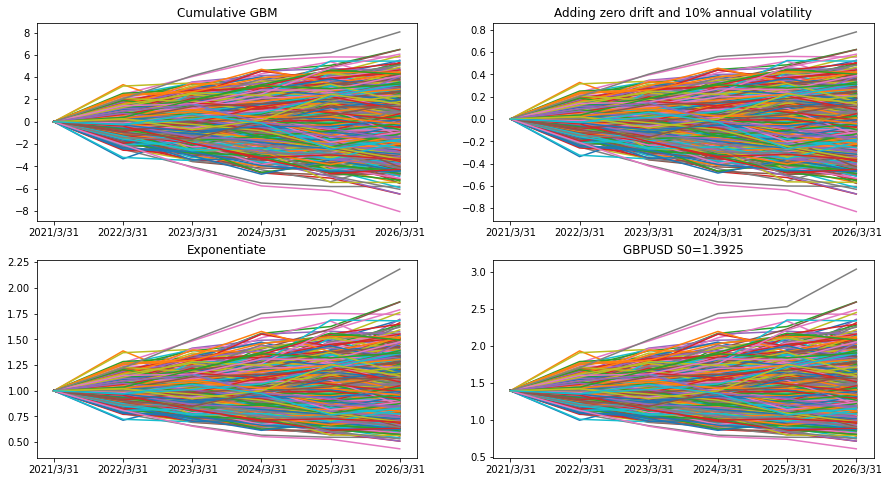

IRR median:  14.5 %
IRR SD:  5.24 %
IRR 95% percentile:  23.2 %
IRR 5% percentile:  6.39 %
IRR TVaR 0.95 is  25.94 %
IRR TVaR 0.05 is  4.09 %

Option value/premium: $ 0.1244753463576042 USD per 1 notional amount of GBP
For 100,000,000 notional GBP, option premium is $ 12447535.0 USD

Hedged IRR median:  12.57 %
Hedged IRR SD:  3.55 %
Hedged IRR 95% percentile:  20.52 %
Hedged IRR 5% percentile:  9.52 %
Hedged IRR TVaR 0.95 is  23.17 %
Hedged IRR TVaR 0.05 is  8.87 %


In [26]:
antitheticIRR(drift, volatility, T, N, S0, GBP_cashflow, dates)

### The simple simulations and antithetic simulations both give very similar results.

### The variance of simulated IRR distribution is not further reduced by the antithetic method.

### Control variate simulation is not applicable in this problem context, since no information is given on any other proxy variable that is correlated with GBPUSD exchange rate.